## Project: Predicting house sale prices  
**Data:** housing data for the city of Ames, Iowa, USA, 2006 to 2010  
**Data description:** https://s3.amazonaws.com/dq-content/307/data_description.txt  
**Source:** https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627  
**Source pdf:** https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true


#### Useful links

Inspiration notebooks:
* https://www.kaggle.com/code/solegalli/feature-engineering-for-house-price-modelling
* https://nycdatascience.com/blog/student-works/house-price-prediction-with-creative-feature-engineering-and-advanced-regression-techniques/
* https://rpubs.com/IsaacGabr/795734
* https://www.kaggle.com/code/modassirafzal/housing-top-3/notebook


Feature Engineering:
* https://towardsdatascience.com/churn-analysis-information-value-and-weight-of-evidence-6a35db8b9ec5  
* https://contrib.scikit-learn.org/category_encoders/woe.html  
* https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence  
* https://contrib.scikit-learn.org/category_encoders/polynomial.html  
* https://contrib.scikit-learn.org/category_encoders/targetencoder.html 
* https://stackoverflow.com/questions/46428870/how-to-handle-date-variable-in-machine-learning-data-pre-processing
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html
* https://www.lexjansen.com/sesug/2014/SD-20.pdf
* https://arxiv.org/pdf/2001.08025.pdf (Optbinning library)

Correlation for non-numeric data (Dython library):  
* https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

Variable standarization:  
http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf

Variable selection:  
* https://github.com/scikit-learn-contrib/boruta_py

Optimal Binning and WoE transformation for continuous dependent variable:
* http://gnpalencia.org/optbinning/binning_continuous.html
* https://www.listendata.com/2019/08/WOE-IV-Continuous-Dependent.html

Diagnostics:
* https://programminghistorian.org/en/lessons/linear-regression#step-8-evaluating-performance  
* https://online.stat.psu.edu/stat462/node/179/
* https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b
* https://medium.com/analytics-vidhya/multi-collinearity-key-aspect-of-regression-problem-9918a1a52559

Regression:
* https://en.wikipedia.org/wiki/Theil%E2%80%93Sen_estimator
* https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso


In [ ]:
# Documentation
# https://thomas-cokelaer.info/tutorials/sphinx/docstring_python.html - 
# for how to docstring documents
# Let's have this project in Sphinx - it will be easier than writing 
# https://python.plainenglish.io/how-to-host-your-sphinx-documentation-on-github-550254f325ae
# https://stackoverflow.com/questions/41052221/what-is-the-difference-between-var-cvar-and-ivar-in-pythons-sphinx


### 1. Setting up environment

#### 1.1 Importing packages & setting-up parameters

In [3]:
# Set-up auto-reload functions for faster debugging 
# (automatically refreshes changes in subpackages codes)
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [4]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath(''))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [24]:
import gp23package.data.make_dataset as gp23md
from IPython.display import display, HTML #  tidied-up display
from time import time #  project timer
from itertools import chain # for list iterations

# plots
import matplotlib.pyplot as plt
import seaborn as sn

# Statistics
from scipy import stats
from scipy.stats import mstats

# Sklearn
from sklearn.feature_selection import (SelectKBest, chi2, f_regression, RFE, mutual_info_regression,
                                      SequentialFeatureSelector, SelectFromModel)
from sklearn.preprocessing import (normalize, MinMaxScaler)
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score)
from sklearn.model_selection import (train_test_split, cross_val_score, KFold, GridSearchCV)
from sklearn.linear_model import (LinearRegression, Ridge, ElasticNet, Lasso, TheilSenRegressor, RANSACRegressor,
                                  HuberRegressor , SGDRegressor, Lars, ElasticNet, RidgeCV)

#statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels as sm
import statsmodels.stats.stattools as smt
import statsmodels.stats.diagnostic as smd

# Other
from dython import nominal # Correlations between categorical variables
from optbinning import ContinuousOptimalBinning # WoE transformations
import distfit #distribution fitting
import session_info # build and requirements.txt

# Necessary packages
import gp23package
import numpy as np
import pandas as pd
import copy # for deepcopy
import math
import pylab
import session_info # build and requirements.txt

#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250

In [21]:
# MANUAL_INPUT - mark of sections of code, that are not automated and have to be manually re-coded to new datasets.

# parameters
seed = 12345
target = 'SalePrice'
ID_vars = ['Order', 'PID']

# Non-numeric variables parameters

low_corr_category_parm = 0.1 # cut-off value for categorical variables correlation.
strong_correlation_param = 0.8 # cut-off value of Pearson correlation to indicate strong correlations
levels_discrete = 20 # how many levels (unique values) can a numeric variable have to be considered as discrete variable 
c_miss_cutoff = 0.8 # delete non-numeric variables that have more than c_miss_cutoff missing values

# Numeric variables paramaters

n_miss_cutoff = 0.25 # delete numeric variables that have more than n_miss_cutoff missing values
n_fill_cutoff = 0.05 # if missing values for numeric variables is ge than n_fill cutoff, use n_fill_method to impute values
n_fill_cutoff = 'mode' # numeric variables imputation method for missing values

#Train valid test split
test_split = 0.8 # 20% of total observations will be assigned to test dataset
valid_split = 0.8 # 20% of train_valid observations ( test_split * total observations) will be assigned to
# validation dataset

# Datasets explained

# Variable selection
low_variance_treshold = 0.01 # low variance treshold. 
# Variables that have less than low_variance_treshold variance in train_valid dataset will be dropped
kbestfeatures = 20 # 20 all variable selection methods will select kbestfeatures best variables

# data_transformed - data post missing values handling and inputation
# train - train dataset (post sampling)
# valid - valid dataset (post sampling)
# train_valid - concatenated train and valid datasets (post sampling). Used for CV purposes.
# test - holdout data for final accuracy confirmation.

#### 1.2 Starting project timer and exporting requirements

In [11]:
# Starting project timer
tic_all = time()

In [12]:
# Collecting packages info and saving to requirements.txt file
session_info.show(cpu = True, std_lib = True, dependencies = True, write_req_file = True,
                  req_file_name = 'requirements.txt')

#### 1.3 Importing and inspecting source data

In [7]:
data = gp23md.MakeDataset('AmesHousing.tsv').data
print(type(data))
display(HTML(data.head().to_html()))

<class 'pandas.core.frame.DataFrame'>


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [15]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

### 2. Exploratory Data Analysis (EDA)

#### 2.1 Non-numeric Data

In [17]:
# MANUAL_INPUT
# MS SubClass is a categorical variable stored as number - we will switch it to category
data["MS SubClass"] = 'C' + data["MS SubClass"].astype(str)

In [18]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables \n'.format(len(categorical)))

# Creating Series containing missing information
cat_miss = data[categorical].isnull().sum()/data.shape[0]

# changing missing values in categorical variables to 'Missing'
for var in categorical:
    data[var].fillna('Missing', inplace=True)

# Print basic info about variable - % of missing, # of unique values, unique values in data
for var in categorical:
    valueCounts = pd.concat([data[var].value_counts(), 
                data[var].value_counts(normalize=True).mul(100)],axis=1, keys=('counts','percentage'))
    print(var,'\n',len(data[var].unique()),'unique values: ')
    display(HTML(valueCounts.to_html()))

There are 44 categorical variables 

MS SubClass 
 16 unique values: 


,counts,percentage
C20,1079,36.825939
C60,575,19.624573
C50,287,9.795222
C120,192,6.552901
C30,139,4.744027
C160,129,4.402730
C70,128,4.368601
C80,118,4.027304
C90,109,3.720137
C190,61,2.081911


MS Zoning 
 7 unique values: 


,counts,percentage
RL,2273,77.576792
RM,462,15.767918
FV,139,4.744027
RH,27,0.921502
C (all),25,0.853242
I (all),2,0.068259
A (agr),2,0.068259


Street 
 2 unique values: 


,counts,percentage
Pave,2918,99.590444
Grvl,12,0.409556


Alley 
 3 unique values: 


,counts,percentage
Missing,2732,93.242321
Grvl,120,4.095563
Pave,78,2.662116


Lot Shape 
 4 unique values: 


,counts,percentage
Reg,1859,63.447099
IR1,979,33.412969
IR2,76,2.593857
IR3,16,0.546075


Land Contour 
 4 unique values: 


,counts,percentage
Lvl,2633,89.863481
HLS,120,4.095563
Bnk,117,3.993174
Low,60,2.047782


Utilities 
 3 unique values: 


,counts,percentage
AllPub,2927,99.897611
NoSewr,2,0.068259
NoSeWa,1,0.034130


Lot Config 
 5 unique values: 


,counts,percentage
Inside,2140,73.037543
Corner,511,17.440273
CulDSac,180,6.143345
FR2,85,2.901024
FR3,14,0.477816


Land Slope 
 3 unique values: 


,counts,percentage
Gtl,2789,95.187713
Mod,125,4.266212
Sev,16,0.546075


Neighborhood 
 28 unique values: 


,counts,percentage
NAmes,443,15.119454
CollgCr,267,9.112628
OldTown,239,8.156997
Edwards,194,6.621160
Somerst,182,6.211604
NridgHt,166,5.665529
Gilbert,165,5.631399
Sawyer,151,5.153584
NWAmes,131,4.470990
SawyerW,125,4.266212


Condition 1 
 9 unique values: 


,counts,percentage
Norm,2522,86.075085
Feedr,164,5.597270
Artery,92,3.139932
RRAn,50,1.706485
PosN,39,1.331058
RRAe,28,0.955631
PosA,20,0.682594
RRNn,9,0.307167
RRNe,6,0.204778


Condition 2 
 8 unique values: 


,counts,percentage
Norm,2900,98.976109
Feedr,13,0.443686
Artery,5,0.170648
PosA,4,0.136519
PosN,4,0.136519
RRNn,2,0.068259
RRAe,1,0.034130
RRAn,1,0.034130


Bldg Type 
 5 unique values: 


,counts,percentage
1Fam,2425,82.764505
TwnhsE,233,7.952218
Duplex,109,3.720137
Twnhs,101,3.447099
2fmCon,62,2.116041


House Style 
 8 unique values: 


,counts,percentage
1Story,1481,50.546075
2Story,873,29.795222
1.5Fin,314,10.716724
SLvl,128,4.368601
SFoyer,83,2.832765
2.5Unf,24,0.819113
1.5Unf,19,0.648464
2.5Fin,8,0.273038


Roof Style 
 6 unique values: 


,counts,percentage
Gable,2321,79.215017
Hip,551,18.805461
Gambrel,22,0.750853
Flat,20,0.682594
Mansard,11,0.375427
Shed,5,0.170648


Roof Matl 
 8 unique values: 


,counts,percentage
CompShg,2887,98.532423
Tar&Grv,23,0.784983
WdShake,9,0.307167
WdShngl,7,0.238908
Membran,1,0.034130
ClyTile,1,0.034130
Roll,1,0.034130
Metal,1,0.034130


Exterior 1st 
 16 unique values: 


,counts,percentage
VinylSd,1026,35.017065
MetalSd,450,15.358362
HdBoard,442,15.085324
Wd Sdng,420,14.334471
Plywood,221,7.542662
CemntBd,126,4.300341
BrkFace,88,3.003413
WdShing,56,1.911263
AsbShng,44,1.501706
Stucco,43,1.467577


Exterior 2nd 
 17 unique values: 


,counts,percentage
VinylSd,1015,34.641638
MetalSd,447,15.255973
HdBoard,406,13.856655
Wd Sdng,397,13.549488
Plywood,274,9.351536
CmentBd,126,4.300341
Wd Shng,81,2.764505
Stucco,47,1.604096
BrkFace,47,1.604096
AsbShng,38,1.296928


Mas Vnr Type 
 6 unique values: 


,counts,percentage
None,1752,59.795222
BrkFace,880,30.034130
Stone,249,8.498294
BrkCmn,25,0.853242
Missing,23,0.784983
CBlock,1,0.034130


Exter Qual 
 4 unique values: 


,counts,percentage
TA,1799,61.399317
Gd,989,33.754266
Ex,107,3.651877
Fa,35,1.194539


Exter Cond 
 5 unique values: 


,counts,percentage
TA,2549,86.996587
Gd,299,10.204778
Fa,67,2.286689
Ex,12,0.409556
Po,3,0.102389


Foundation 
 6 unique values: 


,counts,percentage
PConc,1310,44.709898
CBlock,1244,42.457338
BrkTil,311,10.614334
Slab,49,1.672355
Stone,11,0.375427
Wood,5,0.170648


Bsmt Qual 
 6 unique values: 


,counts,percentage
TA,1283,43.788396
Gd,1219,41.604096
Ex,258,8.805461
Fa,88,3.003413
Missing,80,2.730375
Po,2,0.068259


Bsmt Cond 
 6 unique values: 


,counts,percentage
TA,2616,89.283276
Gd,122,4.163823
Fa,104,3.549488
Missing,80,2.730375
Po,5,0.170648
Ex,3,0.102389


Bsmt Exposure 
 5 unique values: 


,counts,percentage
No,1906,65.051195
Av,418,14.266212
Gd,284,9.692833
Mn,239,8.156997
Missing,83,2.832765


BsmtFin Type 1 
 7 unique values: 


,counts,percentage
GLQ,859,29.317406
Unf,851,29.044369
ALQ,429,14.641638
Rec,288,9.829352
BLQ,269,9.180887
LwQ,154,5.255973
Missing,80,2.730375


BsmtFin Type 2 
 7 unique values: 


,counts,percentage
Unf,2499,85.290102
Rec,106,3.617747
LwQ,89,3.037543
Missing,81,2.764505
BLQ,68,2.320819
ALQ,53,1.808874
GLQ,34,1.160410


Heating 
 6 unique values: 


,counts,percentage
GasA,2885,98.464164
GasW,27,0.921502
Grav,9,0.307167
Wall,6,0.204778
OthW,2,0.068259
Floor,1,0.034130


Heating QC 
 5 unique values: 


,counts,percentage
Ex,1495,51.023891
TA,864,29.488055
Gd,476,16.245734
Fa,92,3.139932
Po,3,0.102389


Central Air 
 2 unique values: 


,counts,percentage
Y,2734,93.31058
N,196,6.68942


Electrical 
 6 unique values: 


,counts,percentage
SBrkr,2682,91.535836
FuseA,188,6.416382
FuseF,50,1.706485
FuseP,8,0.273038
Missing,1,0.034130
Mix,1,0.034130


Kitchen Qual 
 5 unique values: 


,counts,percentage
TA,1494,50.989761
Gd,1160,39.590444
Ex,205,6.996587
Fa,70,2.389078
Po,1,0.034130


Functional 
 8 unique values: 


,counts,percentage
Typ,2728,93.105802
Min2,70,2.389078
Min1,65,2.218430
Mod,35,1.194539
Maj1,19,0.648464
Maj2,9,0.307167
Sev,2,0.068259
Sal,2,0.068259


Fireplace Qu 
 6 unique values: 


,counts,percentage
Missing,1422,48.532423
Gd,744,25.392491
TA,600,20.477816
Fa,75,2.559727
Po,46,1.569966
Ex,43,1.467577


Garage Type 
 7 unique values: 


,counts,percentage
Attchd,1731,59.078498
Detchd,782,26.689420
BuiltIn,186,6.348123
Missing,157,5.358362
Basment,36,1.228669
2Types,23,0.784983
CarPort,15,0.511945


Garage Finish 
 4 unique values: 


,counts,percentage
Unf,1231,42.013652
RFn,812,27.713311
Fin,728,24.846416
Missing,159,5.426621


Garage Qual 
 6 unique values: 


,counts,percentage
TA,2615,89.249147
Missing,159,5.426621
Fa,124,4.232082
Gd,24,0.819113
Po,5,0.170648
Ex,3,0.102389


Garage Cond 
 6 unique values: 


,counts,percentage
TA,2665,90.955631
Missing,159,5.426621
Fa,74,2.525597
Gd,15,0.511945
Po,14,0.477816
Ex,3,0.102389


Paved Drive 
 3 unique values: 


,counts,percentage
Y,2652,90.511945
N,216,7.372014
P,62,2.116041


Pool QC 
 5 unique values: 


,counts,percentage
Missing,2917,99.556314
Ex,4,0.136519
Gd,4,0.136519
TA,3,0.102389
Fa,2,0.068259


Fence 
 5 unique values: 


,counts,percentage
Missing,2358,80.477816
MnPrv,330,11.262799
GdPrv,118,4.027304
GdWo,112,3.822526
MnWw,12,0.409556


Misc Feature 
 6 unique values: 


,counts,percentage
Missing,2824,96.382253
Shed,95,3.242321
Gar2,5,0.170648
Othr,4,0.136519
Elev,1,0.034130
TenC,1,0.034130


Sale Type 
 10 unique values: 


,counts,percentage
WD,2536,86.552901
New,239,8.156997
COD,87,2.969283
ConLD,26,0.887372
CWD,12,0.409556
ConLI,9,0.307167
ConLw,8,0.273038
Oth,7,0.238908
Con,5,0.170648
VWD,1,0.034130


Sale Condition 
 6 unique values: 


,counts,percentage
Normal,2413,82.354949
Partial,245,8.361775
Abnorml,190,6.484642
Family,46,1.569966
Alloca,24,0.819113
AdjLand,12,0.409556


In [22]:
# Removing non-numeric variables with too much missing data
print('Variable name   % of missing\n',cat_miss[cat_miss > c_miss_cutoff],'\n',cat_miss[cat_miss > c_miss_cutoff].shape[0],'variables removed.')
for var in cat_miss[cat_miss > c_miss_cutoff].index:
    try:
        categorical.remove(var)
    except:
        print('Variable',var,'is already removed from categorical list.')

print('\nThere are {} categorical variables left for analysis.\n'.format(len(categorical)))

Variable name   % of missing
 Alley           0.932423
Pool QC         0.995563
Fence           0.804778
Misc Feature    0.963823
dtype: float64 
 4 variables removed.

There are 40 categorical variables left for analysis.



In [23]:
# MANUAL_INPUT
# Below variables are numbers stored as string or can be easily translated to numbers (Central Air to binary) 

# Variable value dictionary 
# Ex - Excellent
# Gd - Good
# TA - Typical/Average
# Fa - Fair
# Po - Poor
# Bsmt Qual missing - no basement
# Bsmt Cond missing - no basement
# Garage Qual missing - no garage
# Garage Cond missing - no garage
# Pool QC missing - no pool
# Fireplace Qu missing - no fireplace

for var in ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual', 'Garage Qual', 'Garage Cond', 
    'Fireplace Qu']:
    data[var].replace(['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5], inplace=True)
    data[var]=data[var].astype(int)
    try:
        categorical.remove(var)
    except:
        print('Variable',var,'is already removed from categorical list.')    
    

data['Central Air'].replace(['Y','N'],[1, 0], inplace=True)
data['Central Air']=data['Central Air'].astype(int)
try:
    categorical.remove('Central Air')
except:
    print('Variable Central Air is already removed from categorical list.')

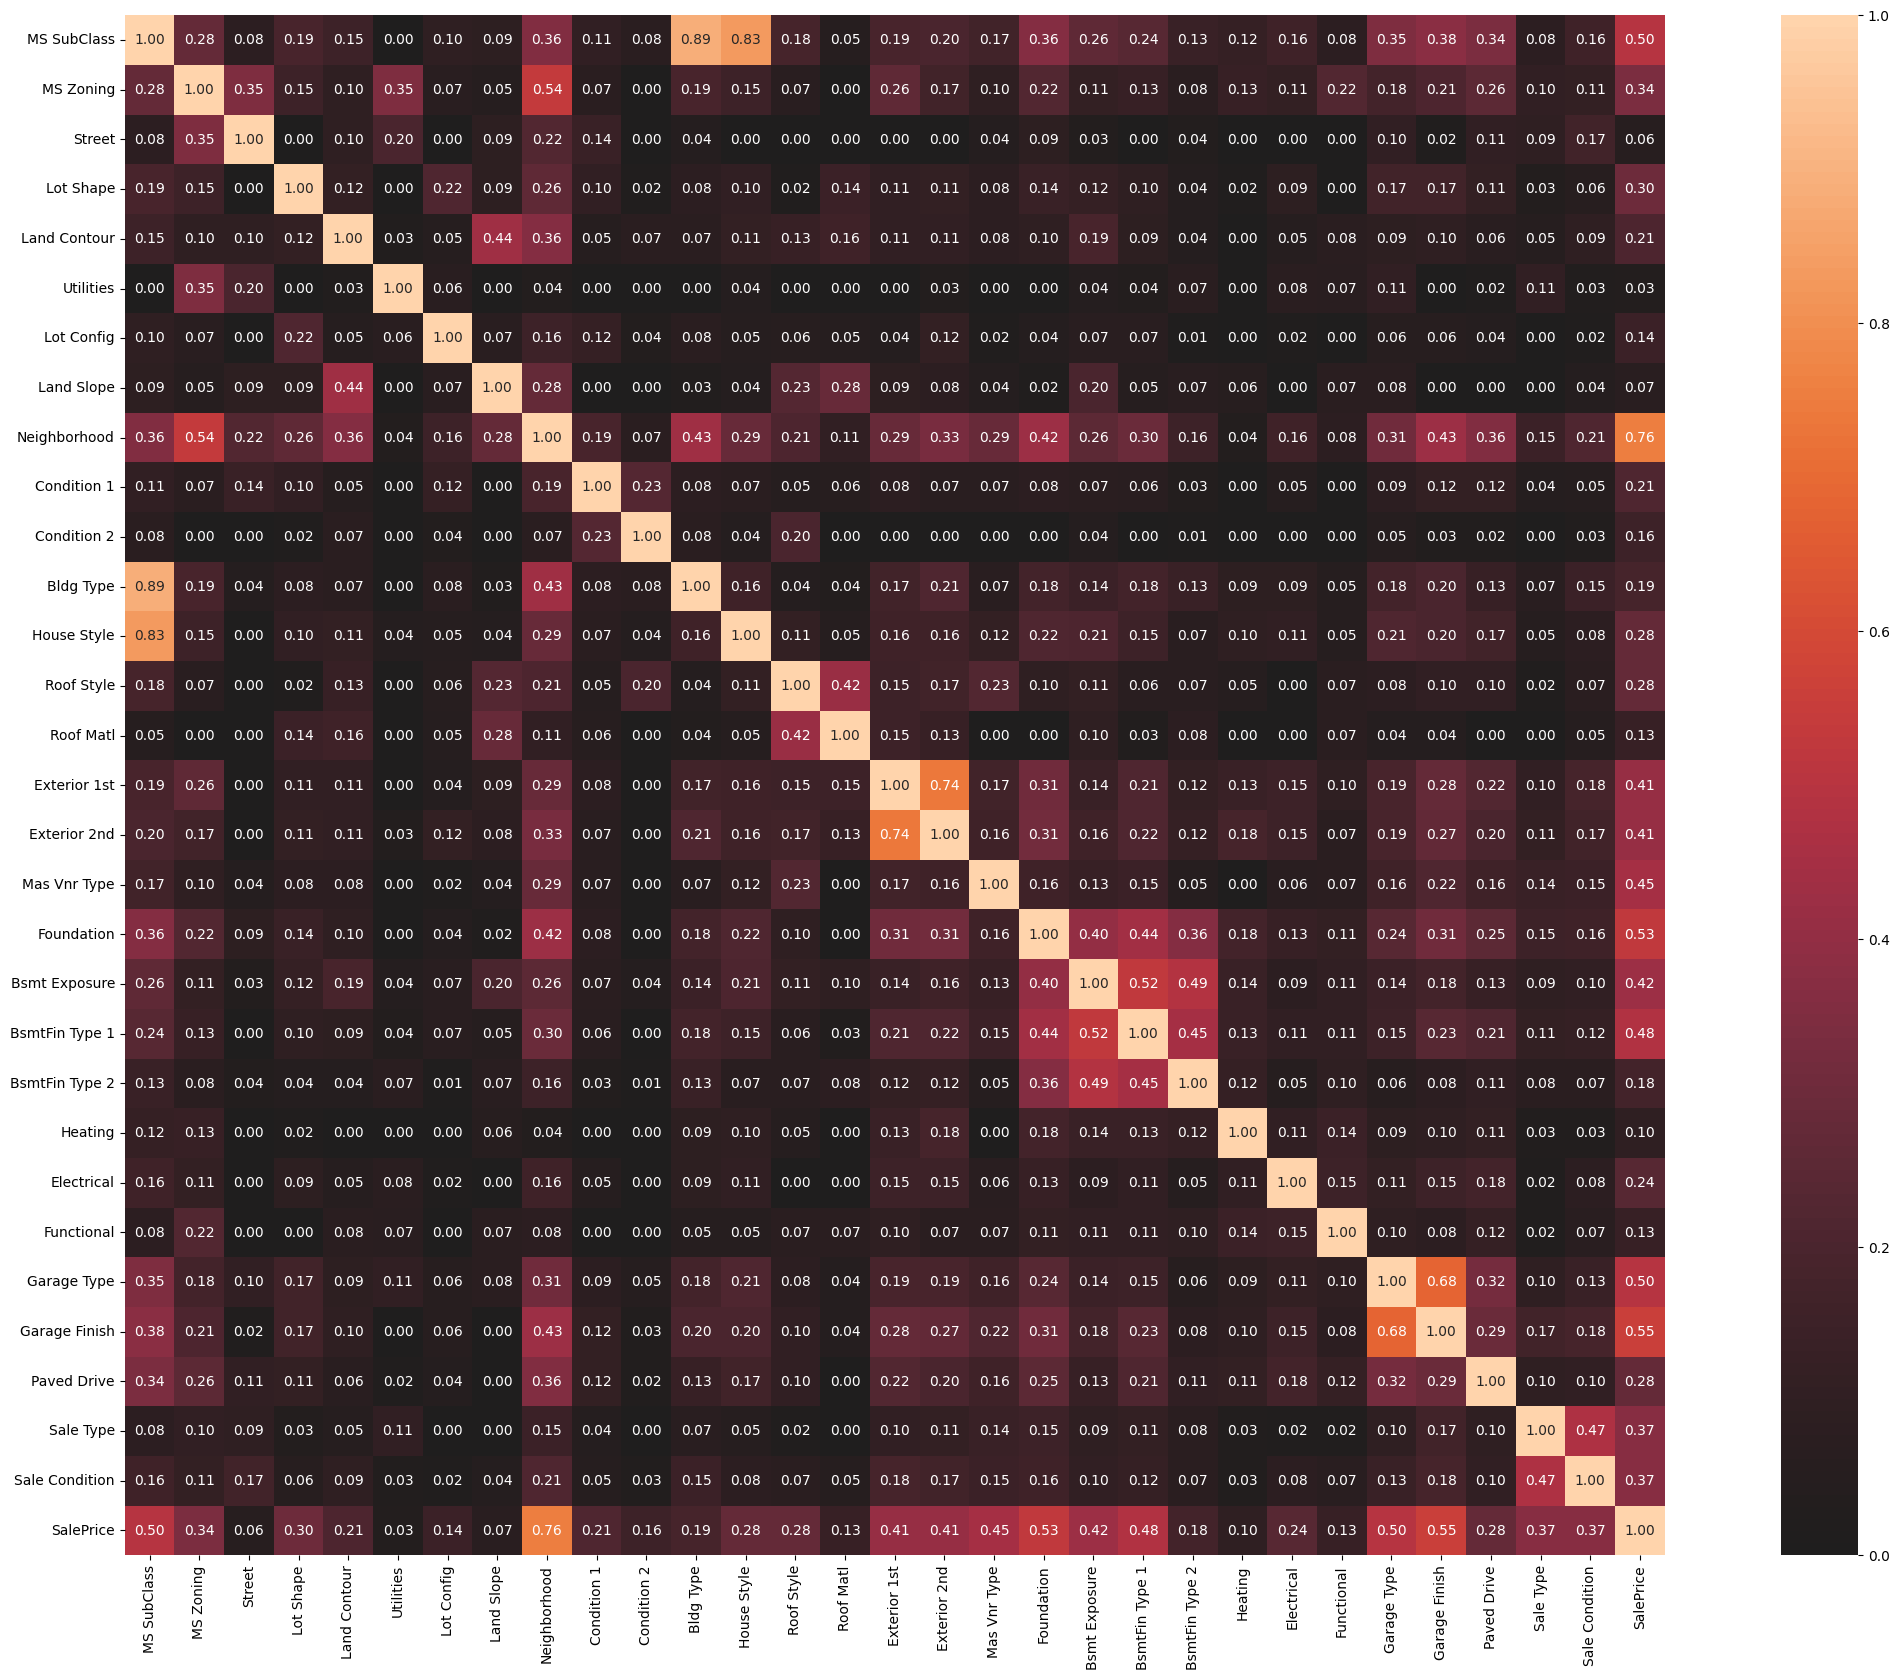

In [25]:
# Correlation for non-numeric variables
# Dython nominal.associations works well with object-type variables, may cause trouble with string-type variables
categorical.append(target)
corr_nom = nominal.associations(data[categorical],figsize=(30,20))
categorical.remove(target)

In [26]:
# Correlation of non-numeric data with target in descending order
category_correlations = corr_nom["corr"][target].sort_values(ascending=False)
print(category_correlations)

SalePrice         1.000000
Neighborhood      0.757151
Garage Finish     0.554700
Foundation        0.529272
Garage Type       0.498820
MS SubClass       0.497762
BsmtFin Type 1    0.477178
Mas Vnr Type      0.445932
Bsmt Exposure     0.424721
Exterior 1st      0.412103
Exterior 2nd      0.411566
Sale Type         0.373915
Sale Condition    0.370903
MS Zoning         0.340301
Lot Shape         0.302770
Roof Style        0.279362
House Style       0.278276
Paved Drive       0.276871
Electrical        0.242098
Condition 1       0.212481
Land Contour      0.209026
Bldg Type         0.185816
BsmtFin Type 2    0.175999
Condition 2       0.156105
Lot Config        0.144932
Functional        0.132555
Roof Matl         0.126682
Heating           0.098599
Land Slope        0.068563
Street            0.059519
Utilities         0.032503
Name: SalePrice, dtype: float64


In [27]:
# Removing non-numeric variables with correlation to target variable that is lower than parameter low_corr_category_param
# Warning: this might save some time for linear models, however you might lose significant information and not recommended 
# for non-linear approaches
for item in category_correlations[category_correlations < low_corr_category_parm].index:
    categorical.remove(item)
    
print('There are {} categorical variables left'.format(len(categorical)))

There are 26 categorical variables left


26 categorical variables will be considered for modeling purposes.  
In order to fit them into model we might consider target encoding, one-hot encoding or some other transformation.

In [ ]:
# MANUAL_INPUT
# Visual investigation of target data by groups
var_boxplot(var = 'Yr Sold', data = data, target = target, title = 'Median of Sale Price by Year')